# Your first simple tool

In the previous lesson we walked through the tool use workflow.  It's time to actually get to work implementing a simple example of tool use.  As a recap, there are up to 4 steps in the tool use process: 

1. **Provide Claude with tools and a user prompt:** (API request)
    * Define the set of tools you want Claude to have access to, including their names, descriptions, and input schemas.
    * Provide a user prompt that may require the use of one or more of these tools to answer.

2. **Claude uses a tool:** (API response)
    * Claude assesses the user prompt and decides whether any of the available tools would help with the user's query or task. If so, it also decides which tool(s) to use and with what input(s).
    * Claude outputs a properly formatted tool use request.
    * The API response will have a `stop_reason` of `tool_use`, indicating that Claude wants to use an external tool.

3. **Extract tool input(s), run code, and return results:** (API request)
    * On the client side, you should extract the tool name and input from Claude's tool use request.
    * Run the actual tool code on the client side.
    * Return the results to Claude by continuing the conversation with a new user message containing a `tool_result` content block.

4. **Claude uses the tool result to formulate a response:** (API response)
    * After receiving the tool results, Claude will use that information to formulate its final response to the original user prompt.

We're going to start with a simple demonstration that only requires "talking" to Claude once (don't worry, we'll get to more exciting examples soon enough!). This means that we won't bother with step 4 yet.  We'll ask Claude to answer a question, Claude will request to use a tool to answer it, and then we'll extract the tool input, run code, and return the resulting value.  

Today's large language models struggle with mathematical operations, as evidenced by the following code. 

We ask Claude to "Multiply 1984135 by 9343116": 

In [22]:
from anthropic import Anthropic
from dotenv import load_dotenv

load_dotenv()

client = Anthropic()

# A relatively simple math problem
response = client.messages.create(
    model="claude-3-haiku-20240307",
    messages=[{"role": "user", "content":"Multiply 1984135 by 9343116. Only respond with the result"}],
    max_tokens=400
)
print(response.content[0].text)

18555375560


We'll likely get a different answer by running the above code multiple times, but this is one answer Claude responded with: 

```
18593367726060
```

The actual correct answer is :

```
18538003464660
```
Claude was *slightly* off by `55364261400`! 

## Tool use to the rescue!

Claude isn't great at doing complex math, so let's enhance Claude's capabilities by providing access to a calculator tool.  

Here's a simple diagram explaining the process: 

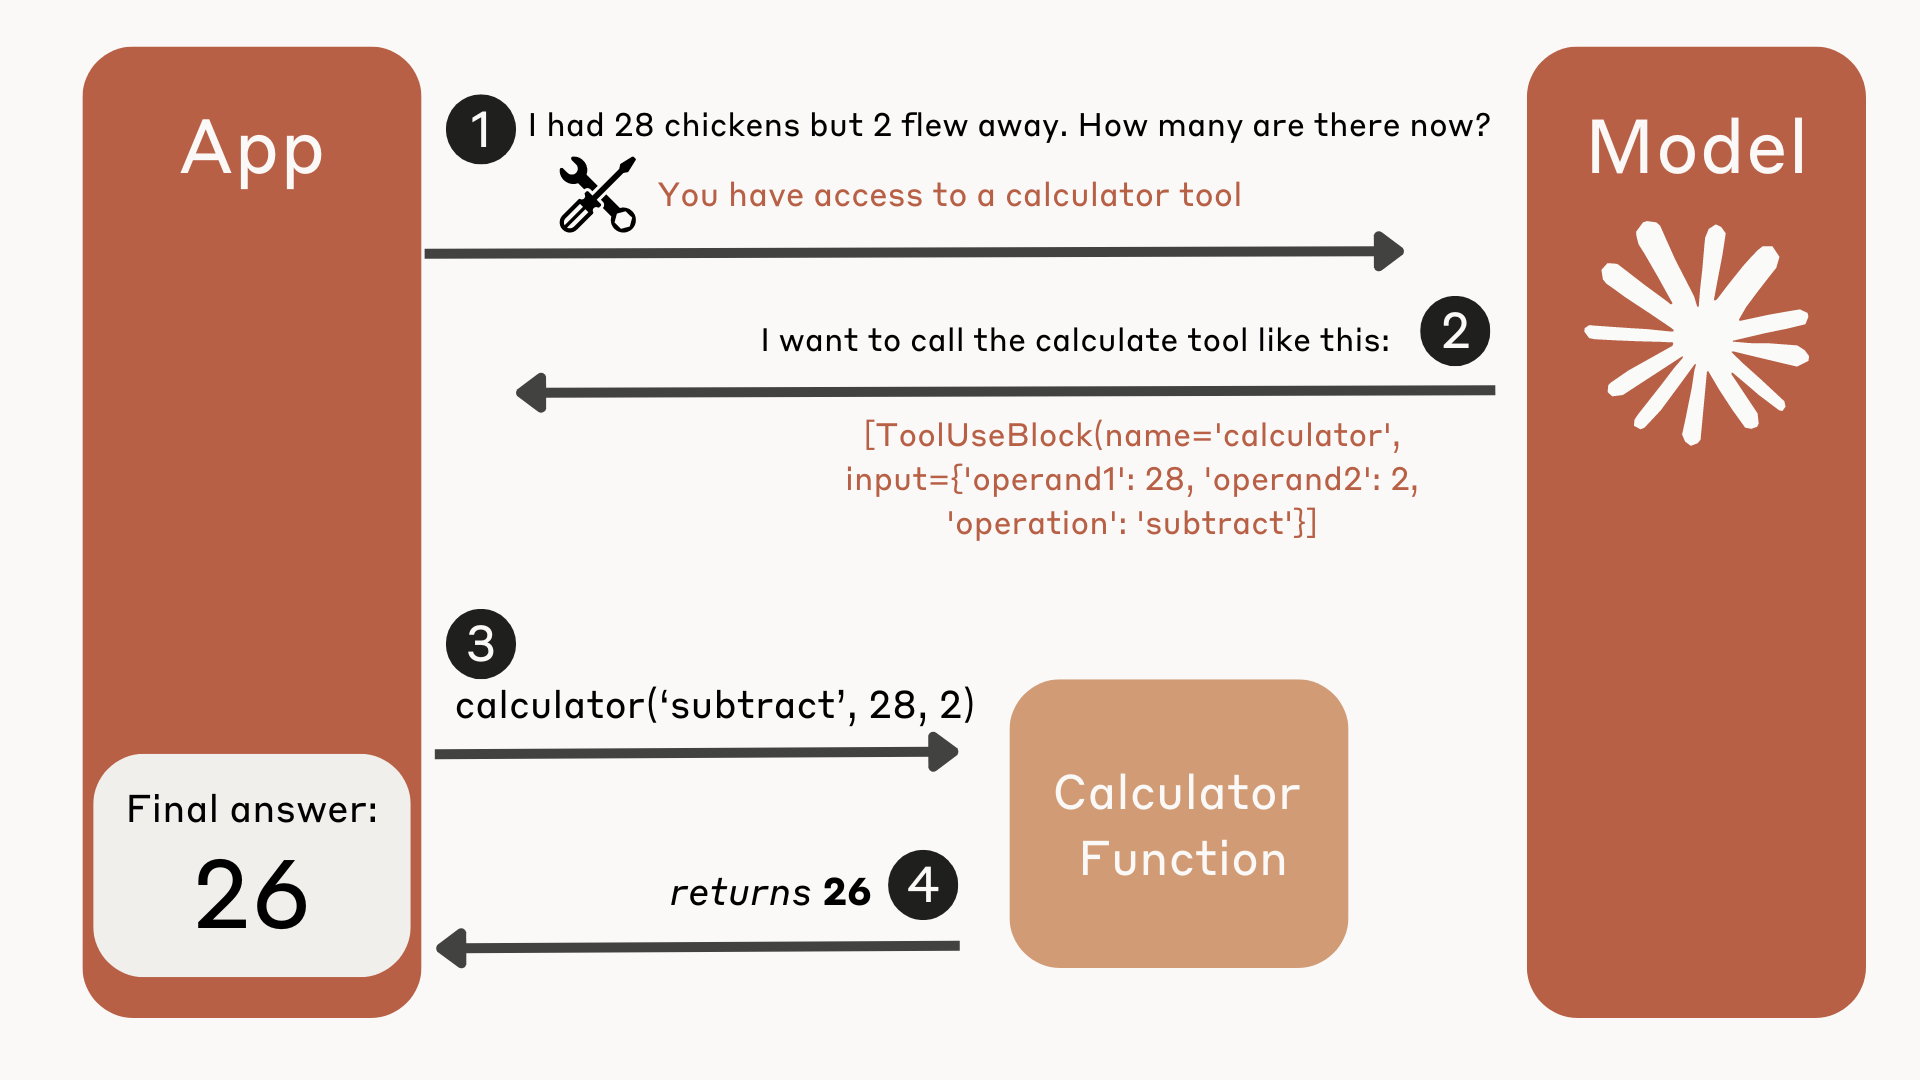

The first step is to define the actual calculator function and make sure it works, indepent of Claude.  We'll write a VERY simple function that expects three arguments:
* An operation like "add" or "multiply"
* Two operands

Here's a basic implementation:

In [23]:
def calculator(operation, operand1, operand2):
    if operation == "add":
        return operand1 + operand2
    elif operation == "subtract":
        return operand1 - operand2
    elif operation == "multiply":
        return operand1 * operand2
    elif operation == "divide":
        if operand2 == 0:
            raise ValueError("Cannot divide by zero.")
        return operand1 / operand2
    else:
        raise ValueError(f"Unsupported operation: {operation}")

Please note that this simple function is quite limited in its utility because it can only handle simple expressions like `234 + 213` or `3 * 9`.  The point here is to go through the process of working with tools via a very simple educational example.

Let's test out our function and make sure it works.

In [24]:
calculator("add", 10, 3)

13

In [25]:
calculator("divide", 200, 25)

8.0

The next step is to define our tool and tell Claude about it.  When defining a tool, we follow a very specific format. Each tool definition includes:

* `name`: The name of the tool. Must match the regular expression ^[a-zA-Z0-9_-]{1,64}$.
* `description`: A detailed plaintext description of what the tool does, when it should be used, and how it behaves.
* `input_schema`: A JSON Schema object defining the expected parameters for the tool.

Unfamiliar with JSON Schema? [Learn more here](https://json-schema.org/learn/getting-started-step-by-step).

Here's a simple example for a hypothetical tool:

```json
{
  "name": "send_email",
  "description": "Sends an email to the specified recipient with the given subject and body.",
  "input_schema": {
    "type": "object",
    "properties": {
      "to": {
        "type": "string",
        "description": "The email address of the recipient"
      },
      "subject": {
        "type": "string",
        "description": "The subject line of the email"
      },
      "body": {
        "type": "string",
        "description": "The content of the email message"
      }
    },
    "required": ["to", "subject", "body"]
  }
}
```

This tool, named `send_email`, expects the following inputs:
* `to` which is a string and is required
* `subject` which is a string and is required
* `body` which is a string and is required


Here's another tool definition for a tool called `search_product`: 

```json
{
  "name": "search_product",
  "description": "Search for a product by name or keyword and return its current price and availability.",
  "input_schema": {
    "type": "object",
    "properties": {
      "query": {
        "type": "string",
        "description": "The product name or search keyword, e.g. 'iPhone 13 Pro' or 'wireless headphones'"
      },
      "category": {
        "type": "string",
        "enum": ["electronics", "clothing", "home", "toys", "sports"],
        "description": "The product category to narrow down the search results"
      },
      "max_price": {
        "type": "number",
        "description": "The maximum price of the product, used to filter the search results"
      }
    },
    "required": ["query"]
  }
}
```
This tool has 3 inputs: 
* A required `query` string representing the product name or search keyword
* An optional `category` string that must be one of the predefined values to narrow down the search.  Notice the `"enum"` in the definition.
* An optional `max_price` number to filter results below a certain price point

### Our calculator tool definition
Let's define the corresponding tool for our calculator function we wrote earlier.  We know that the calculator function has 3 required arguments: 
* `operation` - which can only be "add", "subtract", "multiply", or "divide"
* `operand1` which should be a number
* `operand2` which should also be a number

Here's the tool definition:

In [ ]:
calculator_tool = {
    "name": "calculator",
    "description": "A simple calculator that performs basic arithmetic operations.",
    "input_schema": {
        "type": "object",
        "properties": {
            "operation": {
                "type": "string",
                "enum": ["add", "subtract", "multiply", "divide"],
                "description": "The arithmetic operation to perform."
            },
            "operand1": {
                "type": "number",
                "description": "The first operand."
            },
            "operand2": {
                "type": "number",
                "description": "The second operand."
            }
        },
        "required": ["operation", "operand1", "operand2"]
    }
}

***

## Exercise

Let’s practice writing a properly formatted tool definition using the following function as an example:

In [ ]:
def inventory_lookup(product_name, max_results):
    return "this function doesn't do anything"
    #You do not need to touch this or do anything with it!

This hypothetical `inventory_lookup` function should be called like this:

In [ ]:
inventory_lookup("AA batteries", 4)

inventory_lookup("birthday candle", 10)

Your task is to write a corresponding, properly-formatted tool definition.  Assume both arguments are required in your tool definition.

***

### Providing Claude with our tool
Now back to our calculator function from earlier. At this point, Claude knows nothing about the calculator tool! It's just a little Python dictionary.  When making our request to Claude, we can pass a list of tools to "tell" Claude about.  Let's try it now:

In [38]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    messages=[{"role": "user", "content": "Multiply 1984135 by 9343116. Only respond with the result"}],
    max_tokens=300,
    # Tell Claude about our tool
    tools=[calculator_tool]
)

Next, let's take a look at the response Claude gives us back:

In [42]:
response

ToolsBetaMessage(id='msg_01UfKwdmEsgTh99wfpgW4NJ7', content=[ToolUseBlock(id='toolu_015wQ7Wipo589yT9B3YTwjF1', input={'operand1': 1984135, 'operand2': 9343116, 'operation': 'multiply'}, name='calculator', type='tool_use')], model='claude-3-haiku-20240307', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=420, output_tokens=93))

```
ToolsBetaMessage(id='msg_01UfKwdmEsgTh99wfpgW4NJ7', content=[ToolUseBlock(id='toolu_015wQ7Wipo589yT9B3YTwjF1', input={'operand1': 1984135, 'operand2': 9343116, 'operation': 'multiply'}, name='calculator', type='tool_use')], model='claude-3-haiku-20240307', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=420, output_tokens=93))
```

You might notice that our response looks a bit different that it normally does! Specifically, instead of a plain `Message` we're now getting a `ToolsMessage`.

Additionally, we can check `response.stop_reason` and see that Claude stopped because it decided it was time to use a tool:


In [44]:
response.stop_reason

'tool_use'

`response.content` contains a list containing a `ToolUseBlock` which itself contains information on the name of the tool and inputs:

In [43]:
response.content

[ToolUseBlock(id='toolu_015wQ7Wipo589yT9B3YTwjF1', input={'operand1': 1984135, 'operand2': 9343116, 'operation': 'multiply'}, name='calculator', type='tool_use')]

In [48]:
tool_name = response.content[0].name
tool_inputs = response.content[0].input

print("The Tool Name Claude Wants To Call:", tool_name)
print("The Inputs Claude Wants To Call It With:", tool_inputs)

The Tool Name Claude Wants To Call: calculator
The Inputs Claude Wants To Call It With: {'operand1': 1984135, 'operand2': 9343116, 'operation': 'multiply'}


The next step is to simply take the tool name and inputs that Claude provided us with and use them to actually call the calculator function we wrote earlier.  Then we'll have our final answer! 

In [49]:
operation = tool_inputs["operation"]
operand1 = tool_inputs["operand1"]
operand2 = tool_inputs["operand2"]

result = calculator(operation, operand1, operand2)
print("RESULT IS", result)

RESULT IS 18538003464660


We got the correct answer of `18538003464660`!!! Instead of relying on Claude to get the math correct, we simply ask Claude a question and give it access to a tool it can decide to use if necessary.  

#### Important note
If we ask Claude something that does not require tool use, in this case something that has nothing to do with math or calculations, we probably want it to respond as normal. Claude will usually do this, but sometimes Claude is very eager to use its tools! 

Here's an example where sometimes Claude tries to use the calculator even though it doesn't make sense to use it. Let's see what happens when we ask Claude, "What color are emeralds?"

In [77]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    messages=[{"role": "user", "content":"What color are emeralds?"}],
    max_tokens=400,
    tools=[calculator_tool]
)

In [78]:
response

ToolsBetaMessage(id='msg_01Dj82HdyrxGJpi8XVtqEYvs', content=[ToolUseBlock(id='toolu_01Xo7x3dV1FVoBSGntHNAX4Q', input={'operand1': 0, 'operand2': 0, 'operation': 'add'}, name='calculator', type='tool_use')], model='claude-3-haiku-20240307', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=409, output_tokens=89))

Claude gives us this response: 

```
ToolsBetaMessage(id='msg_01Dj82HdyrxGJpi8XVtqEYvs', content=[ToolUseBlock(id='toolu_01Xo7x3dV1FVoBSGntHNAX4Q', input={'operand1': 0, 'operand2': 0, 'operation': 'add'}, name='calculator', type='tool_use')], model='claude-3-haiku-20240307', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=409, output_tokens=89))

```
Claude wants us to call the calculator tool? A very easy fix is to adjust our prompt or add a system prompt that says something along the lines of: `You have access to tools, but only use them when necessary. If a tool is not required, respond as normal`:

In [79]:
response = client.messages.create(
    model="claude-3-haiku-20240307",
    system="You have access to tools, but only use them when necessary.  If a tool is not required, respond as normal",
    messages=[{"role": "user", "content":"What color are emeralds?"}],
    max_tokens=400,
    tools=[calculator_tool]
)

In [80]:
response

ToolsBetaMessage(id='msg_01YRRfnUUhP1u5ojr9iWZGGu', content=[TextBlock(text='Emeralds are green in color.', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=434, output_tokens=12))

Now Claude responds back with appropriate content and doesn't try to shoehorn tool usage when it doesn't make sense.  This is the new response we get: 

```
'Emeralds are green in color.'
```

We can also see that `stop_reason` is now `end_turn` instead of `tool_use`.

In [81]:
response.stop_reason

'end_turn'

***

### Putting it all together

In [2]:
def calculator(operation, operand1, operand2):
    if operation == "add":
        return operand1 + operand2
    elif operation == "subtract":
        return operand1 - operand2
    elif operation == "multiply":
        return operand1 * operand2
    elif operation == "divide":
        if operand2 == 0:
            raise ValueError("Cannot divide by zero.")
        return operand1 / operand2
    else:
        raise ValueError(f"Unsupported operation: {operation}")


calculator_tool = {
    "name": "calculator",
    "description": "A simple calculator that performs basic arithmetic operations.",
    "input_schema": {
        "type": "object",
        "properties": {
            "operation": {
                "type": "string",
                "enum": ["add", "subtract", "multiply", "divide"],
                "description": "The arithmetic operation to perform.",
            },
            "operand1": {"type": "number", "description": "The first operand."},
            "operand2": {"type": "number", "description": "The second operand."},
        },
        "required": ["operation", "operand1", "operand2"],
    },
}


def prompt_claude(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        system="You have access to tools, but only use them when necessary. If a tool is not required, respond as normal",
        messages=messages,
        max_tokens=500,
        tools=[calculator_tool],
    )

    if response.stop_reason == "tool_use":
        tool_use = response.content[-1]
        tool_name = tool_use.name
        tool_input = tool_use.input

        if tool_name == "calculator":
            print("Claude wants to use the calculator tool")
            operation = tool_input["operation"]
            operand1 = tool_input["operand1"]
            operand2 = tool_input["operand2"]

            try:
                result = calculator(operation, operand1, operand2)
                print("Calculation result is:", result)
            except ValueError as e:
                print(f"Error: {str(e)}")

    elif response.stop_reason == "end_turn":
        print("Claude didn't want to use a tool")
        print("Claude responded with:")
        print(response.content[0].text)


In [85]:
prompt_claude("I had 23 chickens but 2 flew away.  How many are left?")

Claude want to use the calculator tool
Calculation result is:  21


In [86]:
prompt_claude("What is 201 times 2")

Claude want to use the calculator tool
Calculation result is:  402


In [87]:
prompt_claude("Write me a haiku about the ocean")

Claude didn't want to use a tool
Claude responded with: 
Here is a haiku about the ocean:

Vast blue expanse shines,
Waves crash upon sandy shores,
Ocean's soothing song.


*** 

## Exercise

Your task is to help build out a research assistant using Claude.  A user can enter a topic that they want to research and get a list of Wikipedia article links saved to a markdown file for later reading. We could try asking Claude directly to generate a list of article URLs, but Claude is unreliable with URLs and may hallucinate article URLs. Also, legitimate articles might have moved to a new URL after Claude's training cutoff date.  Instead, we're going to use a tool that connects to the real Wikipedia API to make this work! 

We'll provide Claude with access to a tool that accepts a list of possible Wikipedia article titles that Claude has generated but could have hallucinated. We can use this tool to search Wikipedia to find the actual Wikipedia article titles and URLs to ensure that the final list consists of articles that all actually exist. We’ll then save these article URLs to a markdown file for later reading.

We've provided you with two functions to help:


In [4]:
import wikipedia
def generate_wikipedia_reading_list(research_topic, article_titles):
    wikipedia_articles = []
    for t in article_titles:
        results = wikipedia.search(t)
        try:
            page = wikipedia.page(results[0])
            title = page.title
            url = page.url
            wikipedia_articles.append({"title": title, "url": url})
        except:
            continue
    add_to_research_reading_file(wikipedia_articles, research_topic)

def add_to_research_reading_file(articles, topic):
    with open("output/research_reading.md", "a", encoding="utf-8") as file:
        file.write(f"## {topic} \n")
        for article in articles:
            title = article["title"]
            url = article["url"]
            file.write(f"* [{title}]({url}) \n")
        file.write(f"\n\n")

The first function, `generate_wikipedia_reading_list` expects to be passed a research topic like "The history of Hawaii" or "Pirates across the world" and a list of potential Wikipedia article names that we will have Claude generate.  The function uses the `wikipedia` package to search for corresponding REAL wikipedia pages and builds a list of dictionaries that contain an article's title and URL.

Then it calls `add_to_research_reading_file`, passing in the list of Wikipedia article data and the overall research topic.  This function simply adds markdown links to each of the Wikipedia articles to a file called `output/research_reading.md`.  The filename is hardcoded for now, and the function assumes it exists. It exists in this repo, but you'll need to create it yourself if working somewhere else.

The idea is that we'll have Claude "call" `generate_wikipedia_reading_list` with a list of potential article titles that may or may not be real.  Claude might pass the following input list of article titles, some of which are real Wikipedia articles and some of which are not:

```py
["Piracy", "Famous Pirate Ships", "Golden Age Of Piracy", "List of Pirates", "Pirates and Parrots", "Piracy in the 21st Century"]
```

The `generate_wikipedia_reading_list` function goes through each of those article titles and collects the real article titles and corresponding URLs for any Wikipedia articles that actually exist.  It then calls `add_to_research_reading_file` to write that content to a markdown file for later reference.

### The end goal

Your job is to implement a function called `get_research_help` that accepts a research topic and a desired number of articles. This function should use Claude to actually generate the list of possible Wikipedia articles and call the `generate_wikipedia_reading_list` function from above.  Here are a few example function calls:

```py
get_research_help("Pirates Across The World", 7)

get_research_help("History of Hawaii", 3)

get_research_help("are animals conscious?", 3)
```

After these 3 function calls, this is what our output `research_reading.md` file looks like (check it out for yourself in output/research_reading.md): 

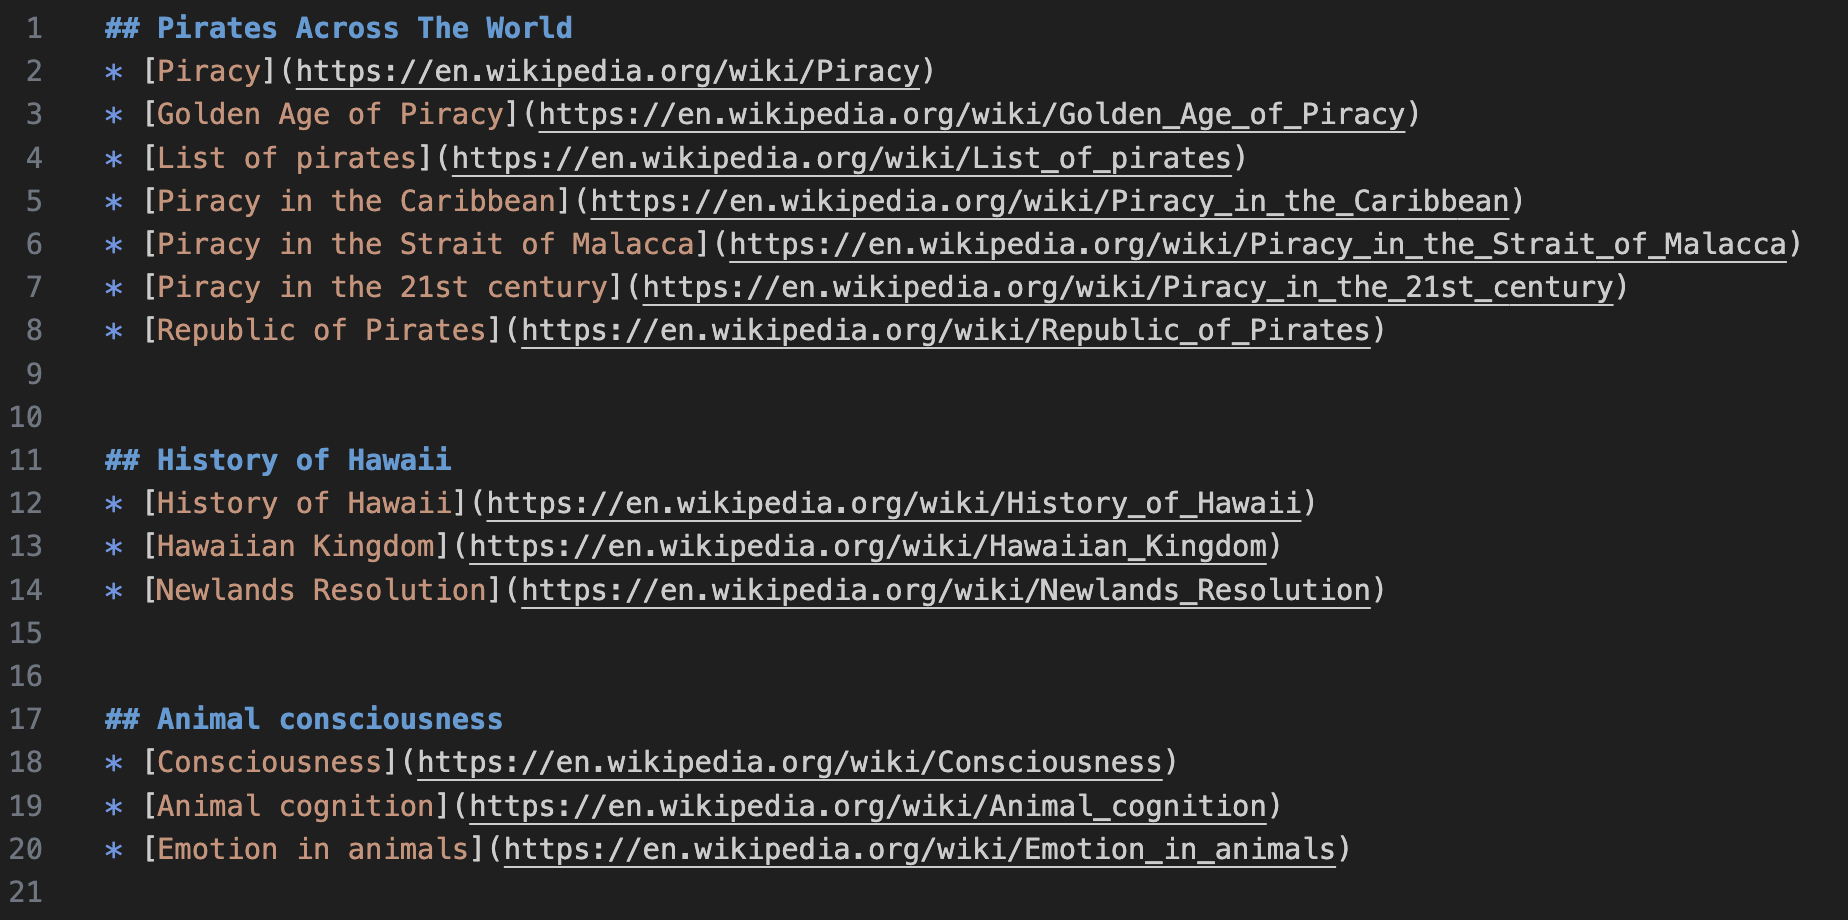



To accomplish this, you'll need to do the following: 

* Write a tool definition for the `generate_wikipedia_reading_list` function
* Implement the `get_research_help` function
    * Write a prompt to Claude telling it that you need help gathering research on the specific topic and how many article titles you want it to generate
    * Tell Claude about the tool it has access to
    * Send off your request to Claude
    * Check to see if Claude called the tool.  If it did, you'll need to pass the article titles and topic it generated to the `generate_wikipedia_reading_list` function we gave you. That function will gather actual Wikipedia article links and then call `add_to_research_reading_file` to write the links to `output/research_reading.md`
    * Open `output/research_reading.md` to see if it worked!


##### Starter Code

In [5]:
# Here's your starter code!
import wikipedia
def generate_wikipedia_reading_list(research_topic, article_titles):
    wikipedia_articles = []
    for t in article_titles:
        results = wikipedia.search(t)
        try:
            page = wikipedia.page(results[0])
            title = page.title
            url = page.url
            wikipedia_articles.append({"title": title, "url": url})
        except:
            continue
    add_to_research_reading_file(wikipedia_articles, research_topic)

def add_to_research_reading_file(articles, topic):
    with open("output/research_reading.md", "a", encoding="utf-8") as file:
        file.write(f"## {topic} \n")
        for article in articles:
            title = article["title"]
            url = article["url"]
            file.write(f"* [{title}]({url}) \n")
        file.write(f"\n\n")
        
def get_research_help(topic, num_articles=3):
   #Implement this function! 
   pass